In [1]:
#Implementation of Shor's Algorithm
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

In [2]:
def c_amod(a, power):
    if a not in [2,5,8,10,11,13,17,19,20]:
        raise ValueError("'a' must be 2,5,8,10,11,13,17,19 or 20")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,20]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [5,19]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 21" % (a, power)
    c_U = U.control()
    return c_U

In [3]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [8]:
# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
n_count = 8
a = 13

qc = QuantumCircuit(n_count + 4, n_count)

# Initialize counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And auxiliary register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw(fold=-1)  # -1 means 'do not fold' 

┌───┐                                                                                                                                     ┌───────┐┌─┐                     
 q_0: ┤ H ├───────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├┤M├─────────────────────
      ├───┤       │                                                                                                                             │       │└╥┘┌─┐                  
 q_1: ┤ H ├───────┼───────────────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─╫─┤M├──────────────────
      ├───┤       │               │                                                                                                             │       │ ║ └╥┘┌─┐               
 q_2: ┤ H ├───────┼───────────────┼───────────────■─────────────────────────────────────────────────────────────────────────────────────────────┤2      ├─╫──╫─┤M├───────────────
      ├───┤       │               │               │                                                                                             │       │ ║  ║ └╥┘┌─┐            
 q_3: ┤ H ├───────┼───────────────┼───────────────┼───────────────■─────────────────────────────────────────────────────────────────────────────┤3      ├─╫──╫──╫─┤M├────────────
      ├───┤       │               │               │               │                                                                             │  QFT† │ ║  ║  ║ └╥┘┌─┐         
 q_4: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────────────■────────────────────────────────────────────────────────────┤4      ├─╫──╫──╫──╫─┤M├─────────
      ├───┤       │               │               │               │                │                                                            │       │ ║  ║  ║  ║ └╥┘┌─┐      
 q_5: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────────────┼────────────────■───────────────────────────────────────────┤5      ├─╫──╫──╫──╫──╫─┤M├──────
      ├───┤       │               │               │               │                │                │                                           │       │ ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_6: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────────────┼────────────────┼────────────────■──────────────────────────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤       │               │               │               │                │                │                │                          │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
 q_7: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────────────┼────────────────┼────────────────┼────────────────■─────────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
      └───┘┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐┌───────┴───────┐┌───────┴───────┐┌───────┴────────┐└───────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 q_8: ─────┤0             ├┤0             ├┤0             ├┤0             ├┤0              ├┤0              ├┤0              ├┤0               ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │              ││              ││              ││              ││               ││               ││               ││                │          ║  ║  ║  ║  ║  ║  ║  ║ 
 q_9: ─────┤1             ├┤1             ├┤1             ├┤1             ├┤1              ├┤1              ├┤1              ├┤1               ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │  13^1 mod 21 ││  13^2 mod 21 ││  13^4 mod 21 ││  13^8 mod 21 ││  13^16 mod 21 ││  13^32 mod 21 ││  13^64 mod 21 ││  13^128 mod 21 │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_10: ─────┤2             ├┤2             ├┤2             ├┤2             ├┤2              ├┤2              ├┤2              ├┤2               ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
      ┌───┐│              ││              ││              ││              ││              

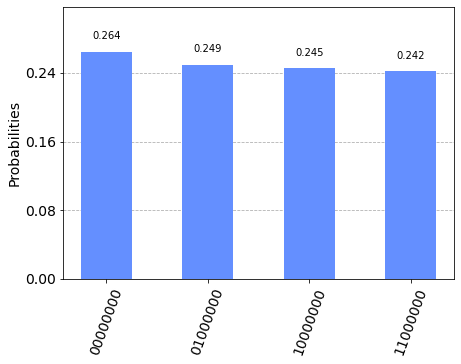

In [9]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, qasm_sim)
qobj = assemble(t_qc)
results = qasm_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)